In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# Set Matplotlib to use LaTeX for text rendering
mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
mpl.rcParams['font.family'] = 'serif'

# Analyze S&P Data

Reproduce Shiller

In [3]:
# extract from shiller's
snp = pd.read_excel("data/shiller_parsed.xlsx")
snp.tail()
# drop 2013 - 2016 due to lack of real Price and real Dividend Data
snp.drop(list(range(142, 146)), axis=0, inplace = True)


Text(0, 0.5, 'Price')

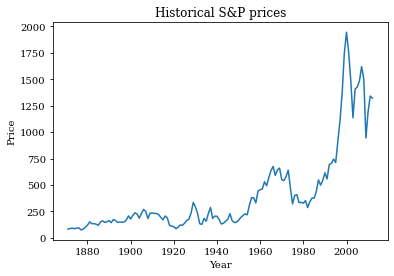

In [4]:
# Historical S&P prices
_=plt.plot(snp['Year'], snp['RealP'])
_=plt.title("Historical S&P prices")
plt.xlabel('Year')
plt.ylabel('Price')

We want to detrend the data according to a long run avg lambda = (1 + g)

Growth Factor (g): 0.017275532726949372


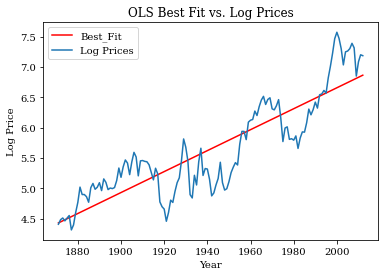

In [5]:
# OLS to get gt + log(P_0) = log(P_t)
X = np.vstack([np.ones_like(snp['Year']), snp['Year']]).transpose()
y = np.log(snp['RealP']).to_numpy()
W = np.linalg.inv(X.transpose() @ X) @ (X.transpose() @ y)
g = W[1]
print("Growth Factor (g):", g)

# Plot log prices vs linear regression
best_fit_y = W @ np.vstack([np.ones_like(snp['Year']), snp['Year']])
plt.plot(snp['Year'], best_fit_y, label ='Best_Fit', c = 'red')
plt.plot(snp['Year'], np.log(snp['RealP']), label = 'Log Prices')
plt.title("OLS Best Fit vs. Log Prices")
plt.xlabel("Year")
plt.ylabel("Log Price")
plt.legend()

In [6]:
# Detrend each price according to (1 + g)^t
snp['detrended_P'] = snp['RealP']/(1+g)**(snp.index)
snp['detrended_P']

0       82.031310
1       86.938590
2       87.876372
3       82.412936
4       84.797362
          ...    
137    143.881214
138     88.809636
139    110.423617
140    121.923587
141    118.077241
Name: detrended_P, Length: 142, dtype: float64

Text(0, 0.5, 'Detrended Price')

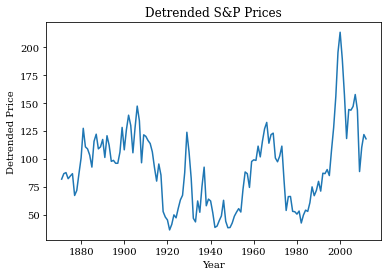

In [7]:
# Plot detrended prices
plt.plot(snp['Year'], snp['detrended_P'])
plt.title("Detrended S&P Prices")
plt.xlabel("Year")
plt.ylabel("Detrended Price")

We also want to compute Dividend growth and detrend it in the same manner.

# Find P* via Dividend Growth Model and detrend

Now that all our dividends and prices are detrended, we would like to determine P*

P* is dependent on the price of future dividends and g. Thus, we must make an assumption regarding future dividends 2013 and after. 

In [8]:
# Compute the geometric return
geo_r = np.exp(np.log(1 + (snp['RealP'].shift(-1) - snp['RealP'] + snp['RealD'])/snp['RealP']).mean()) -1
print("Geometric R:", geo_r)
snp['returns'] = (snp['RealP'].shift(-1) - snp['RealP'] + snp['RealD'])/snp['RealP']

Geometric R: 0.06476967709390702


In [9]:
# Compute P*_2012 (Immediately after the 2012 dividend is paid out), by approximating future dividends via the avg growth
P_star_2012 = snp['RealP'].iloc[-1] # approximate using the true 2012 value, like saying we know for sure the future value is this.
print("P*_2012:", P_star_2012)

# recursively compute new dividends
pstar = [P_star_2012]
for idx, D in enumerate(snp['RealD'].to_numpy()[-2::-1]):
    # append discounted value of future year + current D
    pstar.append(pstar[-1] / (1 + geo_r) + D)

snp['computed_P*'] = np.array(pstar[::-1])
print(snp['computed_P*'])

P*_2012: 1321.322
0       113.143383
1       115.433808
2       117.225748
3       118.276658
4       118.909096
          ...     
137    1124.521100
138    1164.387367
139    1214.446019
140    1267.797828
141    1321.322000
Name: computed_P*, Length: 142, dtype: float64


In [10]:
# Detrend according to same as P
snp['detrended_P*'] = snp['computed_P*']/(1 + g)**(snp.index)

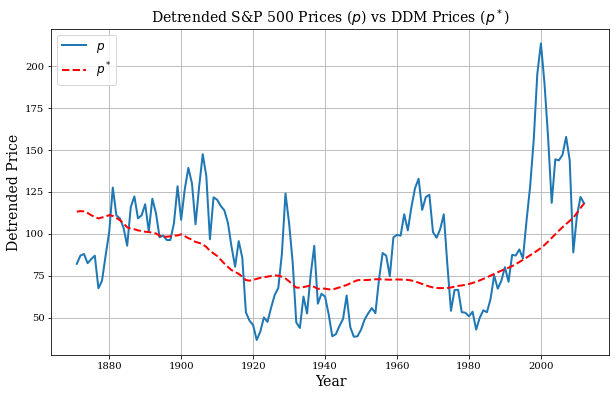

In [11]:
# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(snp['Year'], snp['detrended_P'], label=r'$p$', linewidth=2)
plt.plot(snp['Year'], snp['detrended_P*'], c='red', label=r'$p^*$', linestyle='--', linewidth=2)

# Adding labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Detrended Price', fontsize=14)
plt.title('Detrended S&P 500 Prices ($p$) vs DDM Prices ($p^*$)', fontsize=14)

# Adding a legend
plt.legend(fontsize=12)

# Add grid
plt.grid(True)

# Using a style (optional, uncomment to see effects)
# plt.style.use('seaborn-darkgrid')  # Or 'ggplot', 'classic', etc.

# Show the plot
plt.show()

In [12]:
print("STD P:", snp['detrended_P'].std())
print("STD P*", snp['detrended_P*'].std())

STD P: 34.8462477361639
STD P* 15.59811577790943


This verifies that the std of P > STD P, implying that markets are not following the efficient market hypothesis

## Suppose exact returns are known

In [13]:
# Compute P*_2012 (Immediately after the 2012 dividend is paid out), by approximating future dividends via the avg growth
P_star_2012 = snp['RealP'].iloc[-1] # approximate using the true 2012 value, like saying we know for sure the future value is this.
print("P*_2012:", P_star_2012)

# recursively compute new dividends
pstar = [P_star_2012]
for idx, D in enumerate(snp['RealD'].to_numpy()[-2::-1]):
    # append discounted value of future year + current D
    pstar.append(pstar[-1] / (1 + snp['returns'].iloc[-(idx + 2)]) + D)

snp['computed_P*_exact'] = np.array(pstar[::-1])
print(snp['computed_P*_exact'])

P*_2012: 1321.322
0        87.809404
1        94.360746
2        96.910584
3        92.726380
4        96.700997
          ...     
137    1498.638444
138     951.788194
139    1197.160463
140    1341.333011
141    1321.322000
Name: computed_P*_exact, Length: 142, dtype: float64


In [14]:
snp['detrended_P*_exact'] = snp['computed_P*_exact']/(1 + g)**(snp.index)

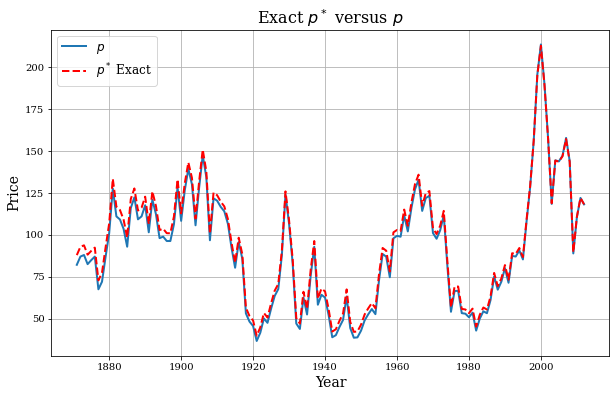

In [15]:
# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(snp['Year'], snp['detrended_P'], label=r'$p$', linewidth=2)
plt.plot(snp['Year'], snp['detrended_P*_exact'], label=r'$p^*$ Exact', linestyle='--', linewidth=2, color='red')

# Adding labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title(r'Exact $p^*$ versus $p$', fontsize=16)

# Adding a legend
plt.legend(fontsize=12)

# Add grid
plt.grid(True)

# Using a style (optional, uncomment to see effects)
# plt.style.use('seaborn-darkgrid')  # Or 'ggplot', 'classic', etc.

# Show the plot
plt.show()

In [16]:
print("STD P:", snp['detrended_P'].std())
print("STD P* Exact", snp['detrended_P*_exact'].std())

STD P: 34.8462477361639
STD P* Exact 34.40469709591939


# Backward Analysis

In [17]:
snp = pd.read_excel("data/shiller_parsed.xlsx")
snp.tail()

,Year,P,D,E,R,RLONG,CPI,RealR,C,Unnamed: 9,...,P*,P*r,P*C,RealD,Return,ln(1+ret),RealE,P/E,E10,P/E10
141,2012,1300.58,31.25,86.51,NaN,1.97,226.665,0.984302,NaN,2012.0,...,NaN,NaN,NaN,31.25,0.144043,0.134569,NaN,14.95779,68.55832,20.26595
142,2013,1480.40,34.99,100.20,NaN,1.91,230.280,NaN,NaN,2013.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.55262,21.59329
143,2014,1822.36,39.44,102.31,NaN,2.86,233.916,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,2015,2028.18,43.39,NaN,NaN,1.88,233.707,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,2016,1918.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# P_t = E[P_t*]
# E[P_t*] = D_{t}(1 + E[G]) E[1/(R-G)]

In [19]:
# at time t, only D_t and P_t are known
# D_t is the dividend paid at time t. P_t is the price after D_t is paid

# we shift RealD to reflect this
snp['P_t'] = snp['RealP']
snp['D_t'] = snp['RealD'].shift(1)

snp[['P_t', 'D_t']]

,P_t,D_t
0,82.03131,NaN
1,88.44050,4.731385
2,90.93882,5.338874
3,86.75833,6.143830
4,90.81064,6.600773
...,...,...
141,1321.32200,26.851520
142,1480.40000,31.250000
143,1794.03300,NaN
144,1998.43900,NaN


In [20]:
# Assume G and R are normally distributed
# Based on historical data, compute a normal distribution
# G - Normal(gmean, gvar)
# R - Normal(rmean, rvar)

# to compute E[1/(R-G)], R and G are not independent, so be construct a bivariate normal distribution

# G, R - Normal([gmean, rmean], [[rvar, rgcov],[rgcov, gvar]])

In [21]:
# Compute historical g and r (only known at )
# logr ~ ln((P_{t+1} + D_t)/P_t))
# D_t was shifted so it matches t+1
snp['logr'] = np.log((snp['P_t'] + snp['D_t'])/snp['P_t'].shift(1))

# logg ~ ln((D_{t+1}/D_t))
snp['logg'] = np.log(snp['D_t']/snp['D_t'].shift(1))
snp[['P_t', 'logr', 'D_t', 'logg']]

,P_t,logr,D_t,logg
0,82.03131,NaN,NaN,NaN
1,88.44050,0.127345,4.731385,NaN
2,90.93882,0.084907,5.338874,0.120797
3,86.75833,0.021360,6.143830,0.140434
4,90.81064,0.115817,6.600773,0.071738
...,...,...,...,...
141,1321.32200,0.005190,26.851520,0.121981
142,1480.40000,0.134569,31.250000,0.151697
143,1794.03300,NaN,NaN,NaN
144,1998.43900,NaN,NaN,NaN


In [22]:
# std of r
sigmar = (np.exp(snp['logr']) - 1).std()
ur = (np.exp(snp['logr'].mean()) - 1)
print("simga r:", sigmar)
print("Mean r:", ur)

simga r: 0.1771966087165512
Mean r: 0.06530827560891406


### Case 1
Use normal distribution from the mean of each step. Then connect the P*

In [23]:
n = 1000
end = 141

sigmar = (np.exp(snp['logr']) - 1).std()
ur = (np.exp(snp['logr'].mean()) - 1)
print("simga r:", sigmar)
print("Mean r:", ur)

vars = []
arrs = []
for i in range(n):
    # Compute P*_2012 (Immediately after the 2012 dividend is paid out), by approximating future dividends via the avg growth
    P_star_2012 = snp['RealP'].iloc[end] # approximate using the true 2012 value, like saying we know for sure the future value is this.
    #print("P*_2012:", P_star_2012)

    # recursively compute new dividends
    pstar = [P_star_2012]
    pstar_avg = [P_star_2012]
    divs = snp['RealD'].iloc[0:142].to_numpy()[-2::-1]
    rs = np.random.normal( ur,sigmar, size=len(divs) )
    for idx, D in enumerate(divs):
        # compute avg too
        pstar_avg.append(pstar_avg[-1] / (1 + ur) + D)
        # append discounted value of future year avg + current D
        pstar.append(pstar_avg[-1] / (1 + rs[idx]) + D)

    pstar = np.array(pstar[::-1])
    # save every 10
    detrended_pstar = pstar/(1 + g)**(np.arange(len(pstar)))
    vars.append(detrended_pstar.var())
    if i % 100 == 0:
        print(f"Ran {i}/{n}")
        arrs.append(detrended_pstar)
    

simga r: 0.1771966087165512
Mean r: 0.06530827560891406
Ran 0/1000
Ran 100/1000
Ran 200/1000
Ran 300/1000
Ran 400/1000
Ran 500/1000
Ran 600/1000
Ran 700/1000
Ran 800/1000
Ran 900/1000


In [24]:
from statsmodels.stats.weightstats import ztest

In [25]:
print("Avg Vol:", np.array(vars).mean()**(1/2))
print("Max Vol:", np.array(vars).max()**(1/2))
print("Min Vol:", np.array(vars).min()**(1/2))


Avg Vol: 21.682932096406134
Max Vol: 28.342067485910793
Min Vol: 17.598975192094915


In [26]:
ztest(np.array(vars)**(1/2), value=34.84625, alternative='smaller')

(-243.6089993678525, 0.0)

In [27]:
snp['r'] = np.exp(snp['logr']) -1
snp['g'] = np.exp(snp['logg']) -1
snp


,Year,P,D,E,R,RLONG,CPI,RealR,C,Unnamed: 9,...,RealE,P/E,E10,P/E10,P_t,D_t,logr,logg,r,g
0,1871,4.44,0.26,0.40,6.35,5.32,12.46406,1.047504,NaN,1871.0,...,7.279054,NaN,NaN,NaN,82.03131,NaN,NaN,NaN,NaN,NaN
1,1872,4.86,0.30,0.43,7.81,5.36,12.65439,1.054320,NaN,1872.0,...,7.652386,12.150000,NaN,NaN,88.44050,4.731385,0.127345,NaN,0.135809,NaN
2,1873,5.11,0.33,0.46,8.35,5.58,12.93981,1.133511,NaN,1873.0,...,8.564127,11.883720,NaN,NaN,90.93882,5.338874,0.084907,0.120797,0.088615,0.128396
3,1874,4.66,0.33,0.46,6.86,5.47,12.36890,1.148076,NaN,1874.0,...,9.201078,10.130430,NaN,NaN,86.75833,6.143830,0.021360,0.140434,0.021590,0.150773
4,1875,4.54,0.30,0.36,4.96,5.07,11.51265,1.114055,NaN,1875.0,...,7.643039,9.869565,NaN,NaN,90.81064,6.600773,0.115817,0.071738,0.122790,0.074374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2012,1300.58,31.25,86.51,NaN,1.97,226.66500,0.984302,NaN,2012.0,...,NaN,14.957790,68.55832,20.26595,1321.32200,26.851520,0.005190,0.121981,0.005204,0.129733
142,2013,1480.40,34.99,100.20,NaN,1.91,230.28000,NaN,NaN,2013.0,...,NaN,NaN,69.55262,21.59329,1480.40000,31.250000,0.134569,0.151697,0.144044,0.163807
143,2014,1822.36,39.44,102.31,NaN,2.86,233.91600,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1794.03300,NaN,NaN,NaN,NaN,NaN
144,2015,2028.18,43.39,NaN,NaN,1.88,233.70700,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1998.43900,NaN,NaN,NaN,NaN,NaN


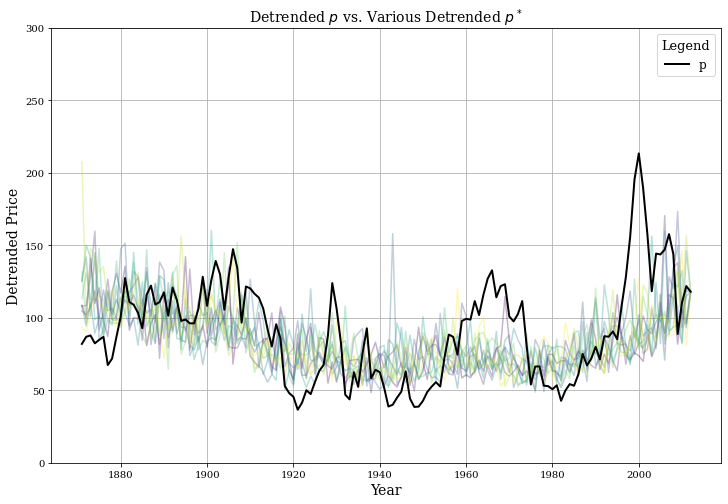

In [28]:
# Plotting
plt.figure(figsize=(12, 8))  # Set the figure size
colors = plt.cm.viridis(np.linspace(0, 1, len(arrs)))  # Color map for multiple lines
for i, a in enumerate(arrs):
    plt.plot(snp['Year'].iloc[0:142], a, alpha=0.3, color=colors[i])  # Adjust alpha for transparency

plt.plot(snp['Year'].iloc[0:142], (snp['RealP']/(1+g)**snp.index).iloc[0:142], label='p', c='black', linewidth=2)

# Setting plot limits, labels, title, and grid
plt.ylim(0, 300)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Detrended Price', fontsize=14)
plt.title(r'Detrended $p$ vs. Various Detrended $p^*$', fontsize=14)
plt.grid(True)
plt.legend(title='Legend', title_fontsize='13', fontsize=12)

# Using a style (optional)
plt.style.use('seaborn-darkgrid')

# Show the plot
plt.show()

# Case 2
Binormal Distribution

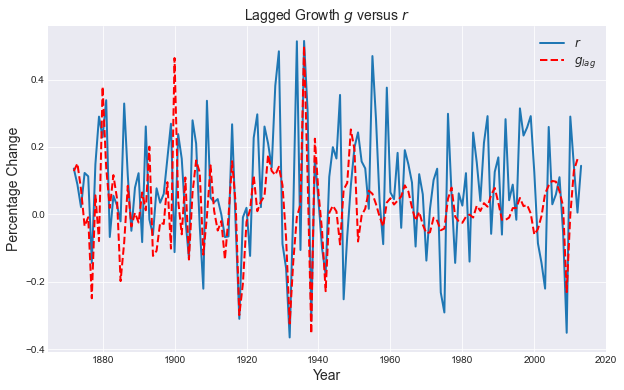

In [29]:
# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(snp['Year'], np.exp(snp['logr']) - 1, label=r'$r$', linewidth=2, )
plt.plot(snp['Year'], np.exp(snp['logg'].shift(-1)) - 1, label=r'$g_{lag}$', linewidth=2, color='red', linestyle='--',)

# plt.plot(snp['Year'], np.exp(snp['logr']) - 1, label=r'$r_{\text{lag}}$', linestyle='--', linewidth=2, marker='x', color='red')

# Adding labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage Change', fontsize=14)
plt.title(r'Lagged Growth $g$ versus $r$', fontsize=14)

# Adding a legend
plt.legend(fontsize=12)

# Add grid
plt.grid(True)

# Using a style (optional, uncomment to see effects)
# # Or 'ggplot', 'classic', etc.

# Show the plot
plt.show()

In [30]:
n = 1000

sigmag = (np.exp(snp['logg']) - 1).std()
ug = (np.exp(snp['logg'].mean()) - 1)

rho = (np.exp((snp['logg'])) - 1).shift(-1).corr((np.exp((snp['logr'])) - 1))
sigmar = (np.exp(snp['logr']) - 1).std()
ur = (np.exp(snp['logr'].mean()) - 1)
print("simga r:", sigmar)
print("Mean r:", ur)
print("sigma g:", sigmag)
print("Mean g:", ug)
print("Corr :", rho)

vars = []
arrs = []
for i in range(n):
    # Compute P*_2012 (Immediately after the 2012 dividend is paid out), by approximating future dividends via the avg growth
    P_star_2012 = snp['RealP'].iloc[141] # approximate using the true 2012 value, like saying we know for sure the future value is this.
    #print("P*_2012:", P_star_2012)

    # recursively compute new dividends
    pstar = [P_star_2012]
    pstar_avg = [P_star_2012]
    divs = snp['RealD'].iloc[1:142].to_numpy()[-2::-1]
    gs = snp['g'].iloc[1:142].to_numpy()[-1::-1]
    for idx, D in enumerate(divs):
        newg = gs[idx]
        newur = ur + rho * (sigmar / sigmag) * (newg - ug)
        # print("New Mean:", newur )
        # print("New Rho:", ((sigmar**2)*(1 - rho**2))**(1/2))
        r = np.random.normal(ur + rho * (sigmar / sigmag) * (newg - ug), ((sigmar**2)*(1 - rho**2))**(1/2), size=1 ).item()
        pstar_avg.append(pstar_avg[-1] / (1 + newur) + D)
        # append discounted value of future year + current D
        pstar.append(pstar_avg[-1] / (1 + r) + D)

    pstar = np.array(pstar[::-1])
    # save every 10
    detrended_pstar = pstar/(1 + g)**(np.arange(len(pstar)))
    vars.append(detrended_pstar.var())
    if i % 100 == 0:
        print(f"Ran {i}/{n}")
        arrs.append(detrended_pstar)
    

simga r: 0.1771966087165512
Mean r: 0.06530827560891406
sigma g: 0.11850201603673988
Mean g: 0.013478691928480613
Corr : 0.4144394660451609
Ran 0/1000
Ran 100/1000
Ran 200/1000
Ran 300/1000
Ran 400/1000
Ran 500/1000
Ran 600/1000
Ran 700/1000
Ran 800/1000
Ran 900/1000


17.18115549103695


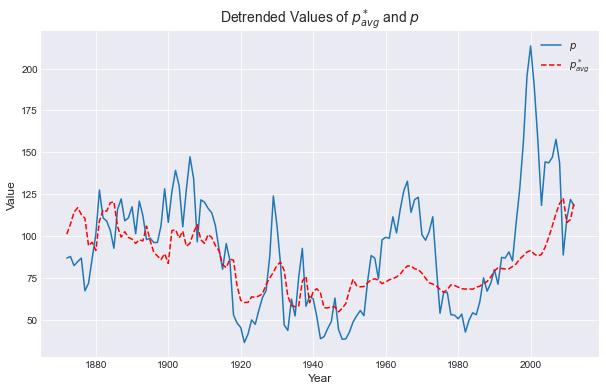

In [31]:
# Assuming pstar_avg is a numpy array with average values and g is the growth rate
# Detrend the average
detrended_pstar_avg = pstar_avg[::-1] / (1 + g)**np.arange(len(pstar_avg))
print(detrended_pstar_avg.std())

# Assuming snp is a DataFrame with 'Year' and 'RealP' columns
years = snp['Year'].iloc[1:142]  # Adjust according to your data
real_p_adjusted = (snp['RealP'] / (1 + g)**snp.index).iloc[1:142]

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
# plt.plot(years, detrended_pstar_avg, label=r'$P_{\text{avg}}$', color='blue')
# plt.plot(years, real_p_adjusted, label=r'$P$', color='black')
plt.title(r'Detrended Values of $p^*_{avg}$ and $p$', fontsize=14)
#Latex

plt.plot(years, real_p_adjusted, label=r'$p$')
plt.plot(years, detrended_pstar_avg, label=r'$p^*_{avg}$', linestyle='--', color='red')
# plt.title(r'Detrended Values of $P_{avg}$ and $P$ Over Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [32]:
print("Avg Vol:", np.array(vars).mean()**(1/2))
print("Max Vol:", np.array(vars).max()**(1/2))
print("Min Vol:", np.array(vars).min()**(1/2))


Avg Vol: 23.356155319724937
Max Vol: 37.86349270741132
Min Vol: 19.32215164108682


In [33]:
ztest(np.array(vars)**(1/2), value=34.84625)

(-213.4819432087123, 0.0)

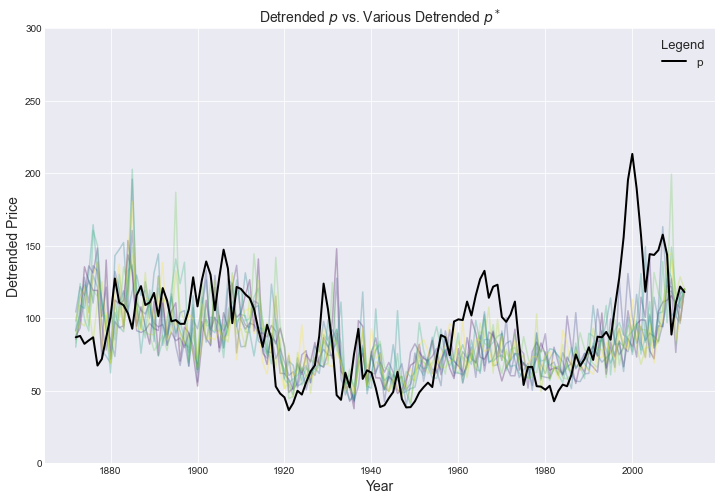

In [34]:
plt.figure(figsize=(12, 8))  # Set the figure size
colors = plt.cm.viridis(np.linspace(0, 1, len(arrs)))  # Color map for multiple lines
for i, a in enumerate(arrs):
    plt.plot(snp['Year'].iloc[1:142], a, alpha=0.3, color=colors[i])  # Adjust alpha for transparency

plt.plot(snp['Year'].iloc[1:142], (snp['RealP'] / (1 + g)**(snp.index)).iloc[1:142], label='p', c='black', linewidth=2)

# Setting plot limits, labels, title, and grid
plt.ylim(0, 300)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Detrended Price', fontsize=14)
plt.title('Detrended $p$ vs. Various Detrended $p^*$', fontsize=14)
plt.grid(True)
plt.legend(title='Legend', title_fontsize='13', fontsize=12)

# Using a style (optional)
# plt.style.use('seaborn-darkgrid')  # Or 'ggplot', 'classic', etc.

# Show the plot
plt.show()

# End of Back Analysis

# Forward Analysis
We assume now, the perspective of an individual who has no knowledge about future dividends, and can only guess a growth rate and return rate to price P*. We want to observe using stat tests how close P* can get to P

In [46]:
# Compute historical means of r and g
snp['rmean'] = np.exp(snp['logr'].cumsum()/snp.index) - 1
snp['gmean'] = np.exp(snp['logg'].cumsum()/(snp.index - 1)) - 1

# If you assume you knew what dividends were going to be
snp['gmean_future'] = snp['gmean'].shift(-1)
snp[['P_t', 'logr', 'D_t', 'logg', 'rmean', 'gmean', 'gmean_future']]

,P_t,logr,D_t,logg,rmean,gmean,gmean_future
0,82.03131,NaN,NaN,NaN,NaN,NaN,NaN
1,88.44050,0.127345,4.731385,NaN,0.135809,NaN,0.128396
2,90.93882,0.084907,5.338874,0.120797,0.111962,0.128396,0.139529
3,86.75833,0.021360,6.143830,0.140434,0.080983,0.139529,0.117383
4,90.81064,0.115817,6.600773,0.071738,0.091286,0.117383,0.077145
...,...,...,...,...,...,...,...
141,1321.32200,0.005190,26.851520,0.121981,0.064770,0.012478,0.013479
142,1480.40000,0.134569,31.250000,0.151697,0.065308,0.013479,NaN
143,1794.03300,NaN,NaN,NaN,NaN,NaN,NaN
144,1998.43900,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
snp['gmean_rolling'] = np.exp(snp['logg'].rolling(20).sum()/20) - 1
snp['rmean_rolling'] = np.exp(snp['logr'].rolling(20).sum()/20) - 1

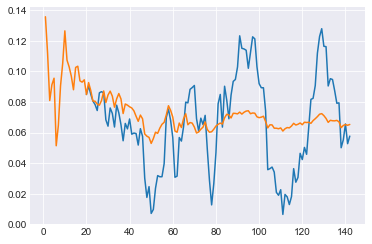

In [51]:
plt.plot(snp['rmean_rolling'])
plt.plot(snp['rmean'])

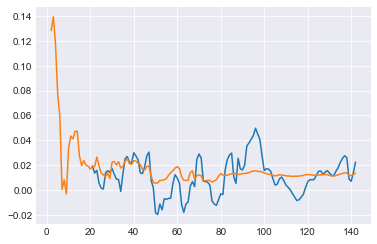

In [49]:
plt.plot(snp['gmean_rolling'])
plt.plot(snp['gmean'])

(0.0, 2000.0)

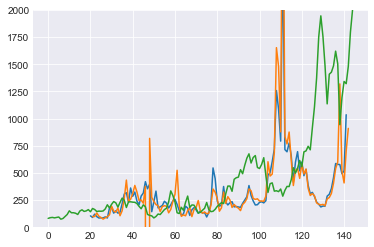

In [63]:
plt.plot(snp['D_t'].shift(-1)/(snp['rmean_rolling'] - snp['gmean_rolling'].shift(-1)))
plt.plot(snp['D_t']*(1+snp['gmean_rolling'])/(snp['rmean_rolling'] - snp['gmean_rolling']))
plt.plot(snp['P_t'])
plt.ylim(0, 2000)

Do some plotting

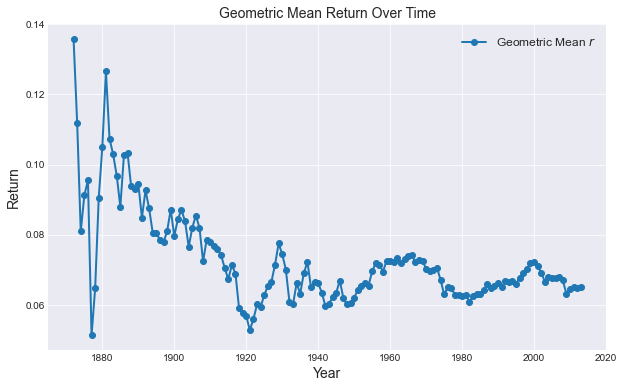

In [36]:
# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(snp['Year'], snp['rmean'], label='Geometric Mean $r$', linewidth=2, marker='o')

# Adding labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Return', fontsize=14)
plt.title('Geometric Mean Return Over Time', fontsize=14)

# Adding a legend
plt.legend(fontsize=12)

# Add grid
plt.grid(True)

# Using a style (optional, uncomment to see effects)
# plt.style.use('seaborn-darkgrid')  # Or 'ggplot', 'classic', etc.

# Show the plot
plt.show()

In [72]:
snp[['Year','rmean_rolling']].head(25)

,Year,rmean_rolling
0,1871,NaN
1,1872,NaN
2,1873,NaN
3,1874,NaN
4,1875,NaN
5,1876,NaN
6,1877,NaN
7,1878,NaN
8,1879,NaN
9,1880,NaN


In [113]:
mpl.rcParams['font.family'] = 'serif'

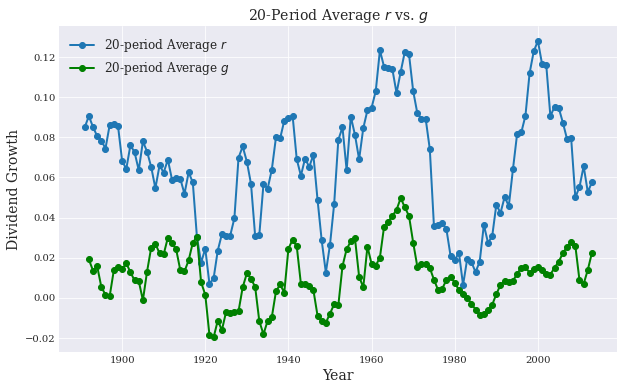

In [114]:
# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(snp['Year'], snp['rmean_rolling'], label=r'20-period Average $r$', linewidth=2, marker='o')
plt.plot(snp['Year'], snp['gmean_rolling'], label=r'20-period Average $g$', linewidth=2, marker='o', color='green')

# Adding labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Dividend Growth', fontsize=14)
plt.title(r'20-Period Average $r$ vs. $g$', fontsize=14)

# Adding a legend
plt.legend(fontsize=12)

# Add grid
plt.grid(True)

# Using a style (optional, uncomment to see effects)
# plt.style.use('seaborn-darkgrid')  # Or 'ggplot', 'classic', etc.

# Show the plot
plt.show()

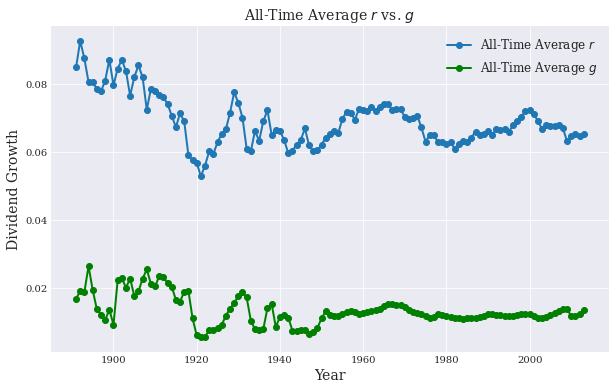

In [115]:
# Plotting
filtered_snp = snp[snp['Year'] >= 1891]

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(filtered_snp['Year'], filtered_snp['rmean'], label=r'All-Time Average $r$', linewidth=2, marker='o')
plt.plot(filtered_snp['Year'], filtered_snp['gmean'], label=r'All-Time Average $g$', linewidth=2, marker='o', color='green')

# Adding labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Dividend Growth', fontsize=14)
plt.xlim(left=1885)
plt.title(r'All-Time Average $r$ vs. $g$', fontsize=14)

# Adding a legend
plt.legend(fontsize=12)

# Add grid
plt.grid(True)

# Using a style (optional, uncomment to see effects)
# plt.style.use('seaborn-darkgrid')  # Or 'ggplot', 'classic', etc.

# Show the plot
plt.show()

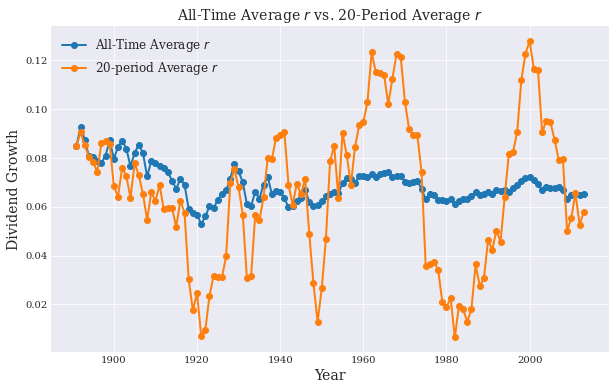

In [116]:
# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(filtered_snp['Year'], filtered_snp['rmean'], label=r'All-Time Average $r$', linewidth=2, marker='o')
plt.plot(snp['Year'], snp['rmean_rolling'], label=r'20-period Average $r$', linewidth=2, marker='o')

# Adding labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Dividend Growth', fontsize=14)
plt.title(r'All-Time Average $r$ vs. 20-Period Average $r$ ', fontsize=14)

# Adding a legend
plt.legend(fontsize=12)

# Add grid
plt.grid(True)

# Using a style (optional, uncomment to see effects)
# plt.style.use('seaborn-darkgrid')  # Or 'ggplot', 'classic', etc.

# Show the plot
plt.show()

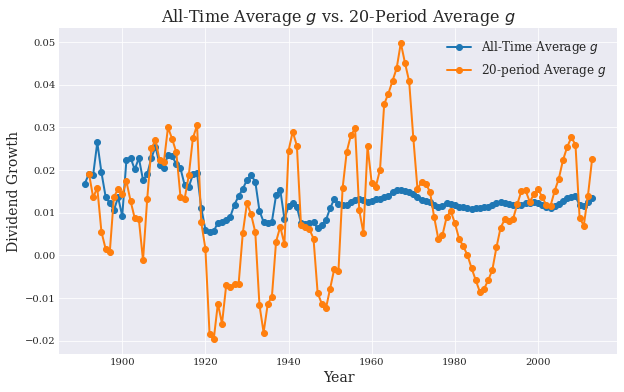

In [123]:
# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(filtered_snp['Year'], filtered_snp['gmean'], label=r'All-Time Average $g$', linewidth=2, marker='o')
plt.plot(snp['Year'], snp['gmean_rolling'], label=r'20-period Average $g$', linewidth=2, marker='o')

# Adding labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Dividend Growth', fontsize=14)
plt.title(r'All-Time Average $g$ vs. 20-Period Average $g$', fontsize=16)

# Adding a legend
plt.legend(fontsize=12)

# Add grid
plt.grid(True)

# Using a style (optional, uncomment to see effects)
# plt.style.use('seaborn-darkgrid')  # Or 'ggplot', 'classic', etc.

# Show the plot
plt.show()

In [118]:
# compute price from means
# use future D1
snp['Phat'] = snp['D_t'].shift(-1)/(snp['rmean'] - snp['gmean_future'])
# use D0 * (1 + gmean)
snp['phat_unknown'] = snp['D_t']*(1 + snp['gmean']) / (snp['rmean'] - snp['gmean'])

In [119]:
g

0.017275532726949372

In [120]:
detrended_phat = snp['Phat']/(1 + g)**(np.arange(len(snp['Phat'])))
detrended_p = snp['P_t']/(1 + g)**(np.arange(len(snp['P_t'])))

In [121]:
snp.columns

Index(['Year', 'P', 'D', 'E', 'R', 'RLONG', 'CPI', 'RealR', 'C', 'Unnamed: 9',
       'RealP', 'P*', 'P*r', 'P*C', 'RealD', 'Return', 'ln(1+ret)', 'RealE',
       'P/E', 'E10', 'P/E10', 'P_t', 'D_t', 'logr', 'logg', 'r', 'g', 'rmean',
       'gmean', 'gmean_future', 'Phat', 'phat_unknown', 'gmean_rolling',
       'rmean_rolling', 'Phat_rolling', 'Phat_rolling_unknown'],
      dtype='object')

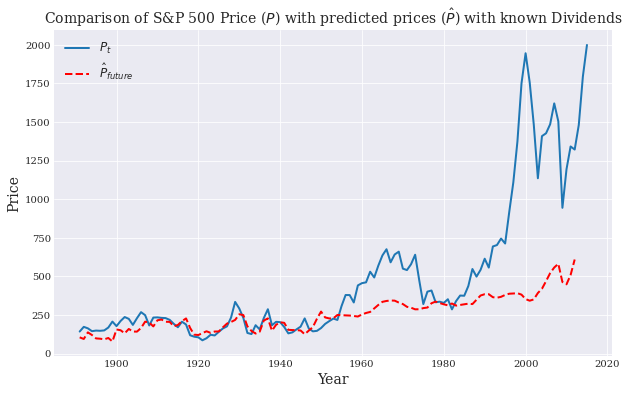

In [124]:
# Skipping the first 20 years
start_year_index = 20  # Adjust based on your DataFrame if needed

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(snp['Year'][start_year_index:], snp['P_t'][start_year_index:], label=r'$P_t$',  linewidth=2)

plt.plot(snp['Year'][start_year_index:], snp['Phat'][start_year_index:], label=r'$\hat{P}_{future}$',linestyle='--',color='red', linewidth=2)

# Adding labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title(r'Comparison of S&P 500 Price ($P$) with predicted prices ($\hat{P}$) with known Dividends', fontsize=14)
# Adding a legend
plt.legend(fontsize=12)

# Add grid
plt.grid(True)

# Using a style (optional)
# plt.style.use('seaborn-darkgrid')  # Or 'ggplot', 'classic', etc.

# Show the plot
plt.show()

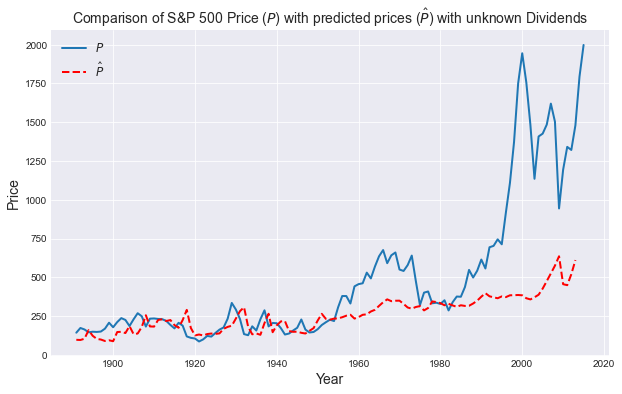

In [108]:

# Skipping the first 20 years
start_year_index = 20  # Adjust based on your DataFrame if needed

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(snp['Year'][start_year_index:], snp['P_t'][start_year_index:], label=r'$P$',  linewidth=2, )

plt.plot(snp['Year'][start_year_index:], snp['phat_unknown'][start_year_index:], label=r'$\hat{P}$', linestyle='--',color='red',linewidth=2)

# Adding labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title(r'Comparison of S&P 500 Price ($P$) with predicted prices ($\hat{P}$) with unknown Dividends', fontsize=14)

# Adding a legend
plt.legend(fontsize=12)

# Add grid
plt.grid(True)

In [109]:
snp

,Year,P,D,E,R,RLONG,CPI,RealR,C,Unnamed: 9,...,g,rmean,gmean,gmean_future,Phat,phat_unknown,gmean_rolling,rmean_rolling,Phat_rolling,Phat_rolling_unknown
0,1871,4.44,0.26,0.40,6.35,5.32,12.46406,1.047504,NaN,1871.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1872,4.86,0.30,0.43,7.81,5.36,12.65439,1.054320,NaN,1872.0,...,NaN,0.135809,NaN,0.128396,720.183026,NaN,NaN,NaN,NaN,NaN
2,1873,5.11,0.33,0.46,8.35,5.58,12.93981,1.133511,NaN,1873.0,...,0.128396,0.111962,0.128396,0.139529,-222.865828,-366.583400,NaN,NaN,NaN,NaN
3,1874,4.66,0.33,0.46,6.86,5.47,12.36890,1.148076,NaN,1874.0,...,0.150773,0.080983,0.139529,0.117383,-181.336979,-119.581445,NaN,NaN,NaN,NaN
4,1875,4.54,0.30,0.36,4.96,5.07,11.51265,1.114055,NaN,1875.0,...,0.074374,0.091286,0.117383,0.077145,450.392650,-282.622926,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2012,1300.58,31.25,86.51,NaN,1.97,226.66500,0.984302,NaN,2012.0,...,0.129733,0.064770,0.012478,0.013479,609.268859,519.902014,0.013975,0.052728,1035.332932,702.579625
142,2013,1480.40,34.99,100.20,NaN,1.91,230.28000,NaN,NaN,2013.0,...,0.163807,0.065308,0.013479,NaN,NaN,611.064316,0.022544,0.057664,NaN,909.863557
143,2014,1822.36,39.44,102.31,NaN,2.86,233.91600,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,2015,2028.18,43.39,NaN,NaN,1.88,233.70700,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
snp['Phat_rolling'] = snp['D_t'].shift(-1)/(snp['rmean_rolling'] - snp['gmean_rolling'].shift(-1))
snp['Phat_rolling_unknown'] = snp['D_t']*(1 + snp['gmean_rolling'])/(snp['rmean_rolling'] - snp['gmean_rolling'])

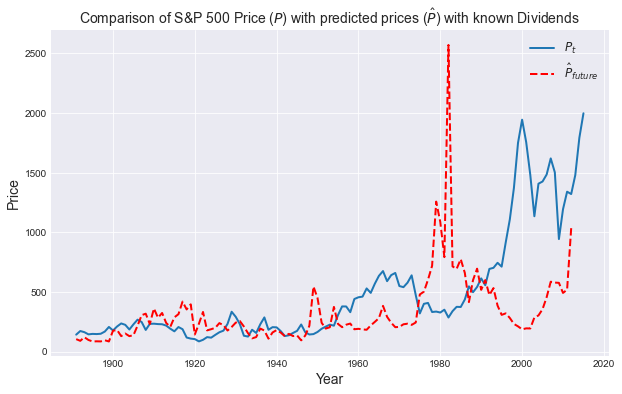

In [111]:
# Skipping the first 20 years
start_year_index = 20  # Adjust based on your DataFrame if needed

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(snp['Year'][start_year_index:], snp['P_t'][start_year_index:], label=r'$P_t$',  linewidth=2)

plt.plot(snp['Year'][start_year_index:], snp['Phat_rolling'][start_year_index:], label=r'$\hat{P}_{future}$',linestyle='--',color='red', linewidth=2)

# Adding labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title(r'Comparison of S&P 500 Price ($P$) with predicted prices ($\hat{P}$) with known Dividends', fontsize=14)
# Adding a legend
plt.legend(fontsize=12)

# Add grid
plt.grid(True)

# Using a style (optional)
# plt.style.use('seaborn-darkgrid')  # Or 'ggplot', 'classic', etc.

# Show the plot
plt.show()

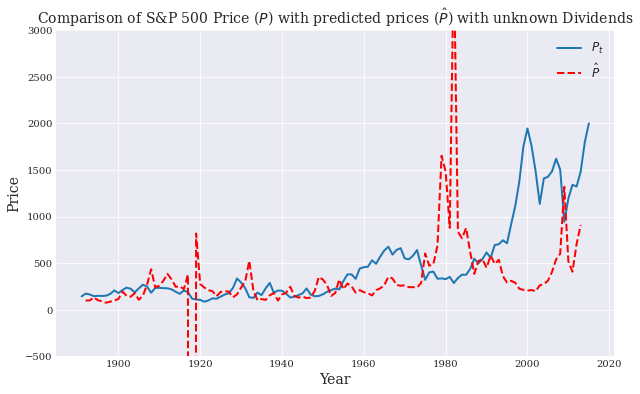

In [125]:
# Skipping the first 20 years
start_year_index = 20  # Adjust based on your DataFrame if needed

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(snp['Year'][start_year_index:], snp['P_t'][start_year_index:], label=r'$P_t$',  linewidth=2)

plt.plot(snp['Year'][start_year_index:], snp['Phat_rolling_unknown'][start_year_index:], label=r'$\hat{P}$',linestyle='--',color='red', linewidth=2)

# Adding labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.ylim(bottom = -500, top = 3000)
plt.title(r'Comparison of S&P 500 Price ($P$) with predicted prices ($\hat{P}$) with unknown Dividends', fontsize=14)
# Adding a legend
plt.legend(fontsize=12)

# Add grid
plt.grid(True)

# Using a style (optional)
# plt.style.use('seaborn-darkgrid')  # Or 'ggplot', 'classic', etc.

# Show the plot
plt.show()